In [ ]:
#                                      U-Net [U-shaped Convolutional Network]

In [ ]:
#                                                  S. Maishal                                                   07-11-2024

In [ ]:
#                                     Indian Institute of Technology, Kharagpur

In [2]:
import xarray as xr
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
netcdf_file = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\CROCO.nc"
ds = xr.open_dataset(netcdf_file)

# Extract data variables
fe = ds['fe'].values  # (time, depth, lat, lon)
po4 = ds['po4'].values
si = ds['si'].values
no3 = ds['no3'].values

# Extract latitude and longitude
latitude = ds['latitude'].values  # Shape: (48,)
longitude = ds['longitude'].values  # Shape: (28,)

# Since depth is constant, discard the depth dimension and focus on (time, lat, lon)
fe = fe[:, 0, :, :]
po4 = po4[:, 0, :, :]
si = si[:, 0, :, :]
no3 = no3[:, 0, :, :]

# Replace NaN values in NO3 with the mean of available values
no3 = np.nan_to_num(no3, nan=np.nanmean(no3))

# Stack the input variables along a new channel dimension (fe, po4, si)
inputs = np.stack([fe, po4, si], axis=-1)  # Shape: (time, lat, lon, channels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, no3, test_size=0.2, random_state=42)

# Normalize the data
scaler_X = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Define the U-Net Model
def build_unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = tf.keras.layers.UpSampling2D((2, 2))(conv3)
    concat1 = tf.keras.layers.Concatenate()([up1, conv2])
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = tf.keras.layers.UpSampling2D((2, 2))(conv4)
    concat2 = tf.keras.layers.Concatenate()([up2, conv1])
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='linear')(conv5)

    model = tf.keras.Model(inputs, outputs)
    return model

# Build and compile the U-Net model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2], X_train_scaled.shape[3])  # (lat, lon, channels)
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test_scaled)

# Make predictions
predictions = model.predict(X_test_scaled)  # Shape: (time, lat, lon, 1)
predictions_reshaped = predictions.squeeze().reshape(-1, 1)  # Reshape to 2D for inverse_transform

# Apply inverse transformation
predicted_no3 = scaler_y.inverse_transform(predictions_reshaped)  # Shape: (time * lat * lon, 1)

# Reshape back to 3D (time, lat, lon)
predicted_no3 = predicted_no3.reshape(predictions.squeeze().shape)

print("Test Loss:", test_loss)

# Save predictions as a NetCDF file
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\unet_no3_predictions.nc"

with xr.Dataset() as ds_out:
    ds_out.coords['latitude'] = ('latitude', latitude)
    ds_out.coords['longitude'] = ('longitude', longitude)
    ds_out.coords['time'] = ('time', np.arange(predicted_no3.shape[0]))
    ds_out['predicted_no3'] = (('time', 'latitude', 'longitude'), predicted_no3)
    ds_out.attrs['title'] = 'U-Net NO3 Predictions'
    ds_out.attrs['description'] = 'Predicted NO3 concentrations using a U-Net model'
    ds_out.to_netcdf(output_file_path)

print(f"Predictions saved to: {output_file_path}")


Epoch 1/50
15/15 [==============================] - 5s 256ms/step - loss: 1.0883 - val_loss: 0.6530
Epoch 2/50
15/15 [==============================] - 4s 247ms/step - loss: 1.0875 - val_loss: 0.6532
Epoch 3/50
15/15 [==============================] - 4s 245ms/step - loss: 1.0837 - val_loss: 0.6431
Epoch 4/50
15/15 [==============================] - 4s 251ms/step - loss: 1.0719 - val_loss: 0.6359
Epoch 5/50
15/15 [==============================] - 4s 251ms/step - loss: 1.0657 - val_loss: 0.6335
Epoch 6/50
15/15 [==============================] - 4s 252ms/step - loss: 1.0536 - val_loss: 0.6204
Epoch 7/50
15/15 [==============================] - 4s 243ms/step - loss: 1.0331 - val_loss: 0.6004
Epoch 8/50
15/15 [==============================] - 4s 250ms/step - loss: 0.9846 - val_loss: 0.6352
Epoch 9/50
15/15 [==============================] - 4s 246ms/step - loss: 0.9247 - val_loss: 0.5301
Epoch 10/50
15/15 [==============================] - 4s 246ms/step - loss: 0.8737 - val_loss: 0.5183

In [6]:
import xarray as xr
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
netcdf_file = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\CROCO.nc"
ds = xr.open_dataset(netcdf_file)

# Extract data variables
fe = ds['fe'].values  # (time, depth, lat, lon)
po4 = ds['po4'].values
si = ds['si'].values
no3 = ds['no3'].values

# Extract latitude and longitude
latitude = ds['latitude'].values  # Shape: (48,)
longitude = ds['longitude'].values  # Shape: (28,)

# Since depth is constant, discard the depth dimension and focus on (time, lat, lon)
fe = fe[:, 0, :, :]
po4 = po4[:, 0, :, :]
si = si[:, 0, :, :]
no3 = no3[:, 0, :, :]

# Replace NaN values in NO3 with the mean of available values
no3 = np.nan_to_num(no3, nan=np.nanmean(no3))

# Stack the input variables along a new channel dimension (fe, po4, si)
inputs = np.stack([fe, po4, si], axis=-1)  # Shape: (time, lat, lon, channels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, no3, test_size=0.2, random_state=42)

# Normalize the data
scaler_X = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Define the U-Net Model
def build_unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = tf.keras.layers.UpSampling2D((2, 2))(conv3)
    concat1 = tf.keras.layers.Concatenate()([up1, conv2])
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = tf.keras.layers.UpSampling2D((2, 2))(conv4)
    concat2 = tf.keras.layers.Concatenate()([up2, conv1])
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='linear')(conv5)

    model = tf.keras.Model(inputs, outputs)
    return model

# Build and compile the U-Net model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2], X_train_scaled.shape[3])  # (lat, lon, channels)
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test_scaled)

# Make predictions
predictions = model.predict(X_test_scaled)  # Shape: (time, lat, lon, 1)
predictions_reshaped = predictions.squeeze().reshape(-1, 1)  # Reshape to 2D for inverse_transform

# Apply inverse transformation
predicted_no3 = scaler_y.inverse_transform(predictions_reshaped)  # Shape: (time * lat * lon, 1)

# Reshape back to 3D (time, lat, lon)
predicted_no3 = predicted_no3.reshape(predictions.squeeze().shape)

# Calculate average actual NO3 for comparison
average_actual_no3 = np.mean(y_test, axis=0)  # Calculate the average for the actual NO3

# Define output file path
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\unet_no3_predictions_final.nc"

# Save both predicted NO3 and actual NO3 averages in the NetCDF file
with xr.Dataset() as ds_out:
    ds_out.coords['latitude'] = ('latitude', latitude)
    ds_out.coords['longitude'] = ('longitude', longitude)
    ds_out.coords['time'] = ('time', np.arange(predicted_no3.shape[0]))

    # Add predicted NO3 and average actual NO3 as variables
    ds_out['predicted_no3'] = (('time', 'latitude', 'longitude'), predicted_no3)
    ds_out['average_actual_no3'] = (('latitude', 'longitude'), average_actual_no3)

    # Set attributes for the dataset and variables
    ds_out.attrs['title'] = 'U-Net NO3 Predictions and Actual Averages'
    ds_out.attrs['description'] = 'Predicted and actual NO3 concentrations using a U-Net model'
    ds_out['predicted_no3'].attrs['units'] = 'mmol m-3'
    ds_out['average_actual_no3'].attrs['units'] = 'mmol m-3'

    # Save the dataset to a NetCDF file
    ds_out.to_netcdf(output_file_path)

print(f"Predictions and actual NO3 averages saved to: {output_file_path}")


Epoch 1/50
15/15 [==============================] - 6s 272ms/step - loss: 1.0878 - val_loss: 0.6522
Epoch 2/50
15/15 [==============================] - 4s 256ms/step - loss: 1.0875 - val_loss: 0.6482
Epoch 3/50
15/15 [==============================] - 4s 254ms/step - loss: 1.0726 - val_loss: 0.6323
Epoch 4/50
15/15 [==============================] - 4s 257ms/step - loss: 1.0511 - val_loss: 0.6390
Epoch 5/50
15/15 [==============================] - 4s 257ms/step - loss: 1.0339 - val_loss: 0.5970
Epoch 6/50
15/15 [==============================] - 4s 255ms/step - loss: 0.9706 - val_loss: 0.5521
Epoch 7/50
15/15 [==============================] - 4s 273ms/step - loss: 0.9214 - val_loss: 0.6201
Epoch 8/50
15/15 [==============================] - 4s 254ms/step - loss: 0.9044 - val_loss: 0.5227
Epoch 9/50
15/15 [==============================] - 4s 272ms/step - loss: 0.8436 - val_loss: 0.5334
Epoch 10/50
15/15 [==============================] - 4s 271ms/step - loss: 0.8410 - val_loss: 0.8420

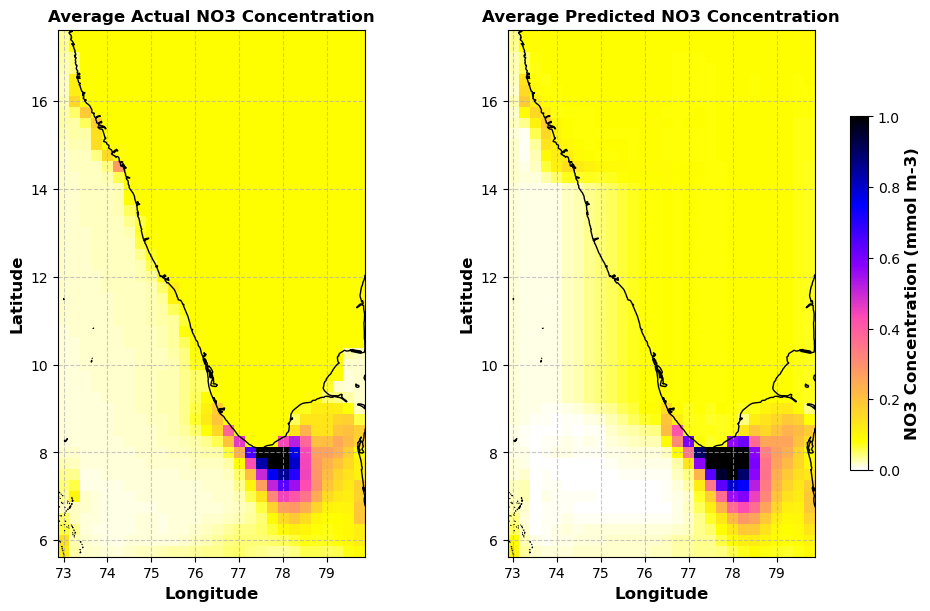

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Define file paths
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\unet_no3_predictions_final.nc"
coastline_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\ne_10m_coastline\ne_10m_coastline.shp"

# Read the NetCDF file using xarray
ds = xr.open_dataset(output_file_path)

# Extract the variables you want to plot
average_actual_no3 = ds['average_actual_no3']  # Actual NO3 (no time dimension)
predicted_no3 = ds['predicted_no3']  # Predicted NO3 (time dimension present)

# Average the predicted NO3 over the time dimension
average_predicted_no3 = predicted_no3.mean(dim='time')  # Averaging over 'time' dimension

# Read the coastline shapefile using geopandas
coastline = gpd.read_file(coastline_file_path)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True, gridspec_kw={'wspace': 0.03})

# Define common vmin and vmax for better color consistency
vmin = 0
vmax = 1.0

# Customize font properties
font_properties = {'fontsize': 12, 'fontweight': 'bold'}

# Plot the average actual NO3 concentration
img1 = average_actual_no3.plot(ax=ax[0], cmap='gnuplot2_r', vmin=vmin, vmax=vmax, add_colorbar=False)
ax[0].set_title('Average Actual NO3 Concentration', **font_properties)
ax[0].set_xlabel('Longitude', **font_properties)
ax[0].set_ylabel('Latitude', **font_properties)
ax[0].grid(True, linestyle='--', alpha=0.7)  # Add grid lines
# Overlay the coastline on the actual NO3 plot
coastline.plot(ax=ax[0], color='black', linewidth=1)

# Plot the average predicted NO3 concentration
img2 = average_predicted_no3.plot(ax=ax[1], cmap='gnuplot2_r', vmin=vmin, vmax=vmax, add_colorbar=False)
ax[1].set_title('Average Predicted NO3 Concentration', **font_properties)
ax[1].set_xlabel('Longitude', **font_properties)
ax[1].set_ylabel('Latitude', **font_properties)
ax[1].grid(True, linestyle='--', alpha=0.7)  # Add grid lines
# Overlay the coastline on the predicted NO3 plot
coastline.plot(ax=ax[1], color='black', linewidth=1)

# Create a single colorbar for both subplots
cbar = fig.colorbar(img1, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('NO3 Concentration (mmol m-3)', **font_properties)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.tick_params(labelsize=10)

# Show the plot
plt.show()

# Close the dataset
ds.close()


In [ ]:
#                                                   Cheers!